In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))

Loaded runs: 572
Loaded final runs: 704
Loaded pdisnn runs: 453


In [75]:
mis_runs_local = load_runs('../sacred_mis/')
print("Loaded mis runs:", len(mis_runs_local.keys()))

Loaded mis runs: 330


In [76]:
# Merge the runs
total_runs = {}
for key, value in mis_runs_local.items():
    total_runs[str(key) + '-mis-local'] = value
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-pdislocal'] = value

In [77]:
base_query = {
    #'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

## Cartpole - Testing consistency

Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20
Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
20


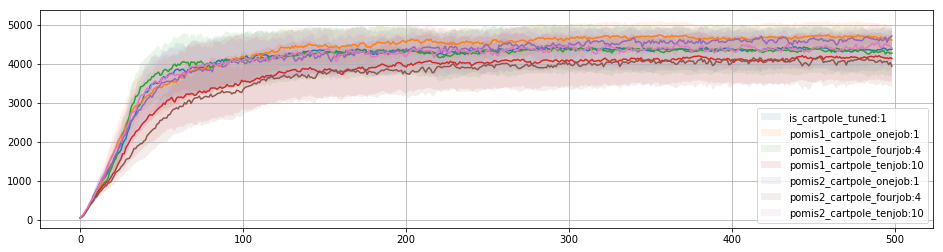

In [30]:
# Seeds: 8, 15, 42, 100, 153, 178, 236, 245, 247, 307, 315, 481, 545, 662, 689, 712, 746, 947, 950, 963
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
for j, (njobs, warm_start, bound, capacity, exp_name) in enumerate([(1, None, 'max-d2', None, 'is_cartpole_tuned'),
                                                             (1, True, 'max-d2-harmonic', 1, 'pomis1_cartpole_onejob'),
                                                             (4, True, 'max-d2-harmonic', 1, 'pomis1_cartpole_fourjob'),
                                                             (10, True, 'max-d2-harmonic', 1, 'pomis1_cartpole_tenjob'),
                                                             (1, True, 'max-d2-harmonic', 1, 'pomis2_cartpole_onejob'),
                                                             (4, True, 'max-d2-harmonic', 1, 'pomis2_cartpole_fourjob'),
                                                             (10, True, 'max-d2-harmonic', 1, 'pomis2_cartpole_tenjob'),
                                                            ]):
    
    query = {
            'config.env': 'rllab.cartpole',
            'config.iw_method': 'is',
            'config.delta': 0.4,
            'config.bound': bound,
            'config.num_episodes': 100,
            'config.policy_init': 'zeros',
            'config.max_offline_iters': 10,
            'config.njobs': njobs,
            'config.warm_start': warm_start,
            'config.capacity': capacity,
            'config.experiment_name': exp_name
        }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    if j == 1:
        filtered_runs = {key: value for key, value in filtered_runs.items() if value['config']['seed'] < 1000}
    print("Seeds:", ", ".join(map(str, sorted([filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()]))))
    print(len([filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()]))
    if j == 14:
        plot_all(filtered_runs, 'EpRewMean', axis)
        print(list(filtered_runs.items())[0][1]['config'])
    elif len(filtered_runs.keys()) > 0:
        plot_mean_ci(filtered_runs, 'EpRewMean', axis, label=exp_name+':'+str(njobs), alpha=0.1)
plt.legend()
plt.grid(True)
plt.show();

## Cartpole - Tuning delta

----------------------------------------
Delta: 0.2
Experiments: 5
Seeds: 160, 570, 10, 109, 904
----------------------------------------
Delta: 0.4
Experiments: 5
Seeds: 109, 10, 160, 904, 570
----------------------------------------
Delta: 0.6
Experiments: 5
Seeds: 904, 10, 570, 109, 160


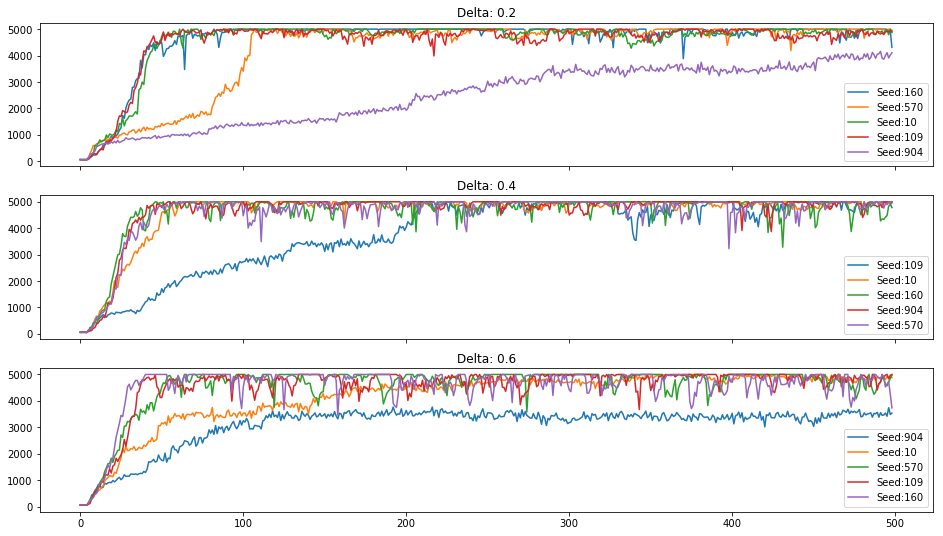

In [31]:
N = 3
fig, axis = plt.subplots(nrows=N, ncols=1, figsize=(16,N*3), sharex=True, sharey=True)
for i, (delta) in enumerate([0.2, 0.4, 0.6]):
    query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'is',
        'config.delta': delta,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.capacity': 5,
        'config.warm_start': True,
        'config.njobs': 10,
        'config.experiment_name': 'pomis2_cartpole_cap5_tuning'
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Delta: " + str(delta))
plt.show();

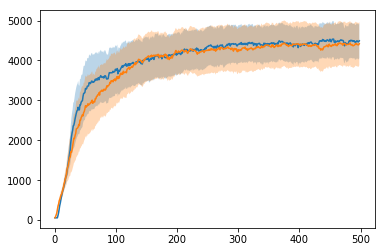

Seeds: 236, 963, 15, 545, 109, 10, 307, 8, 178, 153, 950, 245, 746, 712, 160, 904, 570, 315, 100, 481, 42, 662, 247, 947, 689


In [32]:
query = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'is',
        'config.delta': 0.4,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.capacity': 5,
        'config.warm_start': True,
        'config.njobs': 10,
}
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
query_base = {
        'config.env': 'rllab.cartpole',
        'config.iw_method': 'is',
        'config.delta': 0.4,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.capacity': None,
        'config.warm_start': None,
        'config.njobs': 10,
}
filtered_runs_is = filter_runs({**base_query, **query_base}, total_runs)
plot_mean_ci(filtered_runs_is, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))

## Inverted-pendulum

----------------------------------------
Delta: 0.3
Experiments: 5
Seeds: 10, 160, 904, 109, 570
----------------------------------------
Delta: 0.5
Experiments: 5
Seeds: 570, 904, 160, 109, 10
----------------------------------------
Delta: 0.7
Experiments: 5
Seeds: 109, 570, 10, 904, 160
----------------------------------------
Delta: 0.9
Experiments: 5
Seeds: 160, 904, 109, 10, 570
----------------------------------------
Delta: 0.99
Experiments: 5
Seeds: 570, 904, 109, 10, 160


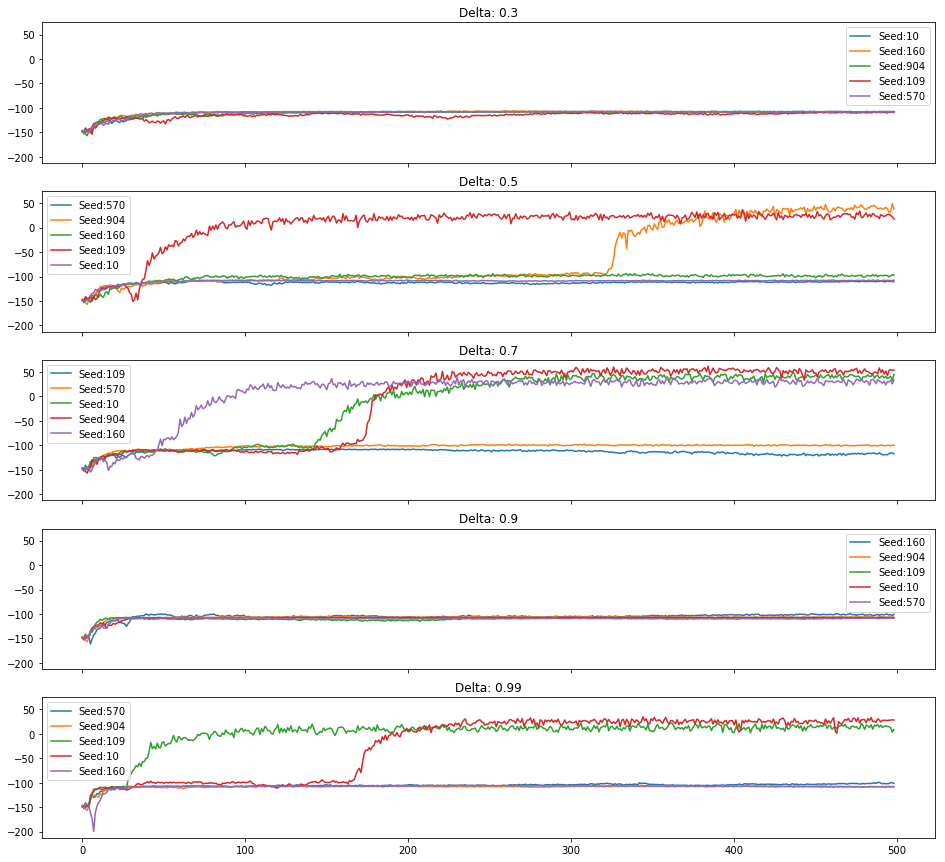

In [41]:
N = 5
fig, axis = plt.subplots(nrows=N, ncols=1, figsize=(16,N*3), sharex=True, sharey=True)
for i, (delta) in enumerate([0.3, 0.5, 0.7, 0.9, 0.99]):
    query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': delta,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.capacity': 5,
        'config.warm_start': True,
        'config.njobs': 10,
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Delta:", str(delta))
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Delta: " + str(delta))
plt.show();

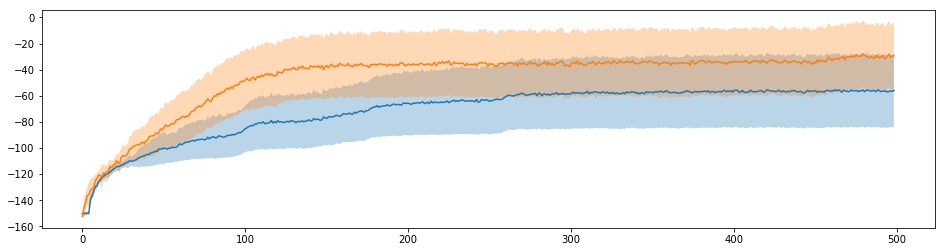

Seeds: 109, 570, 42, 245, 307, 100, 10, 545, 153, 950, 746, 904, 662, 247, 15, 963, 178, 236, 947, 481, 689, 315, 8, 712, 160


In [81]:
query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.7,
        'config.bound': 'max-d2-harmonic',
        'config.num_episodes': 100,
        'config.capacity': 5,
        'config.warm_start': True,
        'config.njobs': 10,
        'config.policy_init': 'zeros'
}
filtered_runs = filter_runs({**base_query, **query}, mis_runs_local)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
plot_mean_ci(filtered_runs, 'EpRewMean', axis)
query_base = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.capacity': None,
        'config.warm_start': None,
        'config.njobs': 1,
}
filtered_runs_is = filter_runs({**base_query, **query_base}, total_runs)
plot_mean_ci(filtered_runs_is, 'EpRewMean', axis)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))